# **Project Description: Sentiment Analysis of Text Data**


---



*This project focuses on building a sentiment analysis model for classifying text data into binary categories: positive or negative. The workflow begins with preprocessing and cleaning the text data using the Natural Language Toolkit (NLTK). This involves tokenization, removal of stop words, and normalization.*

*After preprocessing, the text data is vectorized using Term Frequency-Inverse Document Frequency (TF-IDF) to convert the text into numerical features suitable for training purpose. These features are then used to train a Support Vector Machine (SVM) model with a linear kernel for binary classification.*

*The model's performance is evaluated by calculating accuracy on a test set. Finally, the model is tested with some sample predictions to demonstrate its effectiveness in classifying unseen text data as positive or negative.*


---



***Importing Required Libraries***

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/colab csv files/new_sentiment_data.xlsx"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel(path)

# ***DATA ANALYSIS AND PREPROCESS***

***Dropping other columns, as only the `Ratings` and `Reviews` columns are needed.***

In [ ]:
df = df[['Ratings', 'Reviews']]

In [ ]:
print(f"Data Shape: {df.shape}")


Data Shape: (41142, 2)


***Checking for the presence of null values in the dataset.***

In [ ]:
# Identify columns with NaN values
print(df.isnull().sum())
print("\n")
print(df.isnull().values.any())


Ratings    0
Reviews    0
dtype: int64


False


***Creating the Sentiment column by assigning a target class: 1 for ratings of 3 or higher, and 0 for ratings below 3.***

In [ ]:
df['Sentiment'] = df['Ratings'].apply(lambda x: 0 if x >= 3 else 1)

***Downloading necessary NLTK datasets and initializing stopwords and stemmer for text preprocessing.***

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')  # Ensure punkt is downloaded
nltk.download('punkt_tab')
nltk.download('stopwords')  # Stopwords
nltk.download('vader_lexicon')  # VADER sentiment analysis
nltk.download('averaged_perceptron_tagger_eng')  # POS tagger
nltk.download('wordnet')  # WordNet corpus

# Initialize stopwords and stemmer
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


***Mapping NLTK POS tags to WordNet POS tags and defining a text preprocessing function that includes lowercasing, tokenization, punctuation removal, stopword removal, POS tagging, lemmatization, and reconstruction of cleaned text.***

In [ ]:
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = word_tokenize(text)
    text = [word.strip(string.punctuation) for word in text]
    text = [word for word in text if not any(char.isdigit() for char in word)]
    text = [word for word in text if word not in stop_words]
    text = [word for word in text if len(word) > 0]

    pos_tags = pos_tag(text)
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

    text = [word for word in text if len(word) > 1]
    cleaned_text = " ".join(text)

    return cleaned_text


***Applying the `preprocess_text` function to the `Reviews` column to create a new `Cleaned_Reviews` column.***

In [ ]:
df["Cleaned_Reviews"] = df["Reviews"].apply(preprocess_text)

In [ ]:
df.head()

,Ratings,Reviews,Sentiment,Cleaned_Reviews
0,5.0,Amazing Hotel. Quite affordable. We stayed at ...,0,amazing hotel quite affordable stayed executiv...
1,1.0,Very bad experience at this hotel with low lev...,1,bad experience hotel low level maintenance lac...
2,5.0,Seasonal Tastes by Westin was excellent destin...,0,seasonal taste westin excellent destination su...
3,5.0,All staff is comparative. We mostly like the f...,0,staff comparative mostly like food hotel ambia...
4,4.0,One Of The Best Hotel in Kolkata in terms of l...,0,one best hotel kolkata term luxury amenity bes...


***Performing TF-IDF vectorization on `Cleaned_Reviews` to convert text data into numerical features, and concatenating these features with the original DataFrame for further analysis.***

In [ ]:
tfidf = TfidfVectorizer(min_df = 20)
tfidf_result = tfidf.fit_transform(df["Cleaned_Reviews"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)

In [ ]:
df.head()

,Ratings,Reviews,Sentiment,Cleaned_Reviews,word_aarti,word_able,word_absolute,word_absolutely,word_abul,word_ac,...,word_year,word_yes,word_yesterday,word_yet,word_young,word_yummy,word_zero,word_zone,word_zoo,word_zoological
0,5.0,Amazing Hotel. Quite affordable. We stayed at ...,0,amazing hotel quite affordable stayed executiv...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,Very bad experience at this hotel with low lev...,1,bad experience hotel low level maintenance lac...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,Seasonal Tastes by Westin was excellent destin...,0,seasonal taste westin excellent destination su...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.0,All staff is comparative. We mostly like the f...,0,staff comparative mostly like food hotel ambia...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,One Of The Best Hotel in Kolkata in terms of l...,0,one best hotel kolkata term luxury amenity bes...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.shape

(41142, 1859)

***This code snippet creates a bar chart that visualizes the proportion of each sentiment class from a DataFrame, using a modern seaborn style with percentage labels, customized axes, and a subtle background color.***

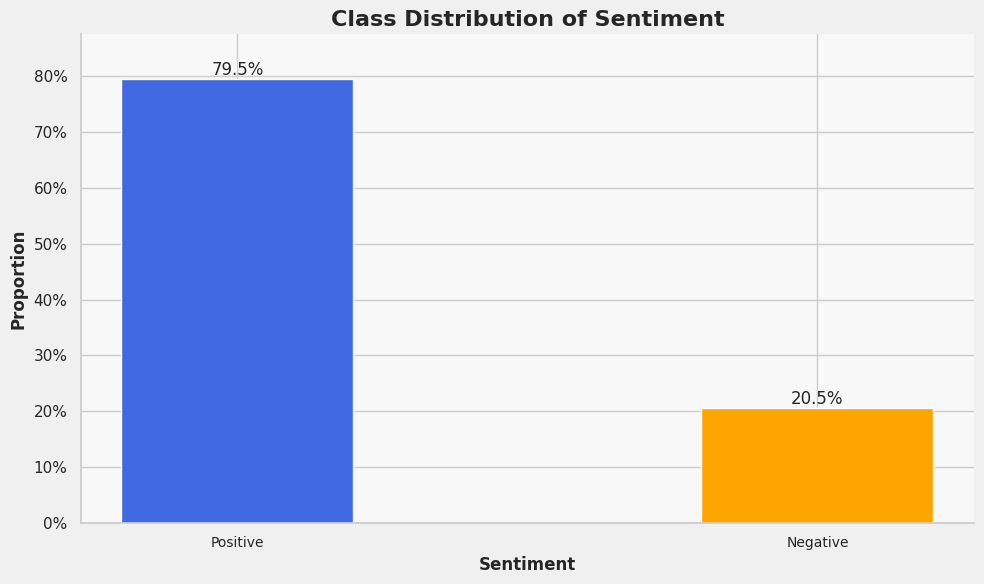

In [ ]:
# Set Seaborn theme
sns.set_theme(style="whitegrid")  # This replaces plt.style.use('whitegrid')
sns.set_palette("deep")

# Get the value counts for the 'Sentiment' column with proportions
sentiment_counts = df['Sentiment'].value_counts(normalize=True)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart
bars = ax.bar(sentiment_counts.index, sentiment_counts.values, width=0.4, color=['royalblue', 'orange'])

# Customize the bars
for bar in bars:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{bar.get_height():.1%}',
        ha='center', va='bottom'
    )

# Set labels and title with custom fonts
ax.set_xlabel('Sentiment', fontsize=12, fontweight='bold')
ax.set_ylabel('Proportion', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution of Sentiment', fontsize=16, fontweight='bold')

# Customize x-axis ticks
ax.set_xticks(sentiment_counts.index)
ax.set_xticklabels(['Positive', 'Negative'], fontsize=10)

# Customize y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylim(0, max(sentiment_counts.values) * 1.1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a subtle background color
fig.patch.set_facecolor('#F0F0F0')
ax.set_facecolor('#F8F8F8')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

***Selecting features for modeling by excluding specified columns such as `Sentiment`, `Reviews`, `Cleaned_Reviews`, and `Ratings`.***

In [ ]:
# feature selection
label = "Sentiment"
ignore_cols = [label, "Reviews", "Cleaned_Reviews", "Ratings"]
features = [c for c in df.columns if c not in ignore_cols]



***Splitting the dataset into training and testing sets, with 20% of the data reserved for testing, and setting a random seed for reproducibility.***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[label], test_size = 0.20, random_state = 42)

***Counting and printing the number of instances of each class (0s and 1s) in both the training and testing sets.***

In [ ]:
# Find the number of 1s and 0s in y_train
train_counts = y_train.value_counts()
train_zeros = train_counts.get(0, 0)
train_ones = train_counts.get(1, 0)

# Find the number of 1s and 0s in y_test
test_counts = y_test.value_counts()
test_zeros = test_counts.get(0, 0)
test_ones = test_counts.get(1, 0)

# Print the results
print(f"Number of 0s in y_train: {train_zeros}")
print(f"Number of 1s in y_train: {train_ones}")
print(f"Number of 0s in y_test: {test_zeros}")
print(f"Number of 1s in y_test: {test_ones}")


Number of 0s in y_train: 26146
Number of 1s in y_train: 6767
Number of 0s in y_test: 6545
Number of 1s in y_test: 1684


***Plotting a bar chart to visualize the distribution of 0s and 1s in y_train and y_test using different colors for each category***


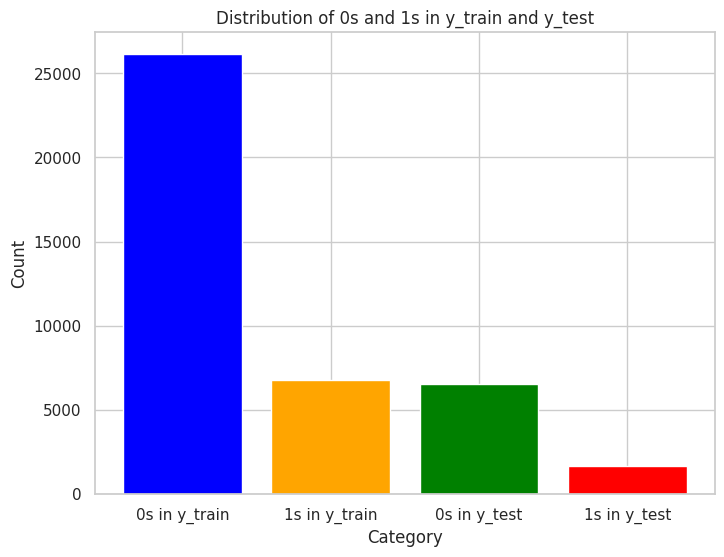

In [ ]:
# Data for the bar chart
categories = ['0s in y_train', '1s in y_train', '0s in y_test', '1s in y_test']
counts = [train_zeros, train_ones, test_zeros, test_ones]

# Plotting the bar chart with different colors
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['blue', 'orange', 'green', 'red'])

# Adding titles and labels
plt.title('Distribution of 0s and 1s in y_train and y_test')
plt.xlabel('Category')
plt.ylabel('Count')

# Display the plot
plt.show()


***Initializing Logistic Regression, Random Forest Classifier and Support Vector Classifier with a linear kernel, balanced class weights, and verbose output.***

In [ ]:
svm = SVC(kernel='linear', class_weight='balanced')
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
rf = RandomForestClassifier(class_weight='balanced')

***Training the Logistic Regression, Random Forest Classifier, Support Vector Classifier on the balanced training data.***

In [ ]:
svm.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

***Making predictions on the test set using the trained Logistic Regression, Random Forest Classifier and Support Vector Classifier models.***

In [ ]:
svm_predictions = svm.predict(X_test)
log_reg_predictions = log_reg.predict(X_test)
rf_predictions = rf.predict(X_test)

***Evaluating the model by calculating and printing the accuracy and the classification report.***

In [ ]:
print("SVM Accuracy: ", accuracy_score(y_test, svm_predictions))
print("Logistic Regression Accuracy: ", accuracy_score(y_test, log_reg_predictions))
print("Random Forest Accuracy: ", accuracy_score(y_test, rf_predictions))

SVM Accuracy:  0.8662048851622312
Logistic Regression Accuracy:  0.8693644428241585
Random Forest Accuracy:  0.9019321910317171


***Transforming new reviews into TF-IDF features, and using the trained SVM classifier to predict and display the sentiment of each review.***

In [ ]:
# Example new reviews to predict
new_reviews = [
    'Absolutely fantastic experience at Taj City Centre Kolkata! The property is beautifully maintained and situated in a very convenient location, just a short distance from the airport. The food at their in-house restaurants was absolutely delicious - less choices but taste was very good', # 5
    'Located in the outskirts of Kolkata, this Taj property is nothing at all like Taj. Bad location, extremely arrogant staff, really poor food quality. Chef argued that the watery white and red sauce for pasta are of right consistency. The pasta was not cooked well. All the curries were bland. Overall bad experience.', # 1
    'I recently booked a luxury room at Taj City Center Newtown Kolkata, however upon arrival, I was told that only smoking rooms were available within the luxury room category, which was disappointing given my preference for a non-smoking environment. Instead of an upgrade, I was offered a deluxe room. The conduct of the front desk staff was subpar, which somewhat marred the initial impression of my stay. Apart from the initial room issue, I enjoyed the spacious and comfortable accommodations, especially the incredibly comfortable beds. Apart from the front desk staff, other staff were friendly and very helpful. The food quality and variety, particularly at the live counters, were exceptional.', # 3
]

# Transform the new reviews into TF-IDF features using the trained TF-IDF vectorizer
new_reviews_vec = tfidf.transform(new_reviews).toarray()

# Make predictions using all three models
svm_predictions = svm.predict(new_reviews_vec)
log_reg_predictions = log_reg.predict(new_reviews_vec)
rf_predictions = rf.predict(new_reviews_vec)

# Output the predictions in a readable format for all models
for review, svm_pred, log_reg_pred, rf_pred in zip(new_reviews, svm_predictions, log_reg_predictions, rf_predictions):
    print(f"Review: '{review}'\n")

    # SVM Prediction
    svm_sentiment = 'Bad Review' if svm_pred == 1 else 'Good Review'
    print(f"SVM Prediction: {svm_sentiment} ({svm_pred})")

    # Logistic Regression Prediction
    log_reg_sentiment = 'Bad Review' if log_reg_pred == 1 else 'Good Review'
    print(f"Logistic Regression Prediction: {log_reg_sentiment} ({log_reg_pred})")

    # Random Forest Prediction
    rf_sentiment = 'Bad Review' if rf_pred == 1 else 'Good Review'
    print(f"Random Forest Prediction: {rf_sentiment} ({rf_pred})\n")


Review: 'Absolutely fantastic experience at Taj City Centre Kolkata! The property is beautifully maintained and situated in a very convenient location, just a short distance from the airport. The food at their in-house restaurants was absolutely delicious - less choices but taste was very good'

SVM Prediction: Good Review (0)
Logistic Regression Prediction: Good Review (0)
Random Forest Prediction: Good Review (0)

Review: 'Located in the outskirts of Kolkata, this Taj property is nothing at all like Taj. Bad location, extremely arrogant staff, really poor food quality. Chef argued that the watery white and red sauce for pasta are of right consistency. The pasta was not cooked well. All the curries were bland. Overall bad experience.'

SVM Prediction: Bad Review (1)
Logistic Regression Prediction: Bad Review (1)
Random Forest Prediction: Bad Review (1)

Review: 'I recently booked a luxury room at Taj City Center Newtown Kolkata, however upon arrival, I was told that only smoking rooms

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
